In [4]:
using PhyloNetworks
using Combinatorics
using Formatting
using SparseArrays
using Distributions
#using Clustering
using MultivariateStats
using StatsBase
using CairoMakie
using GaussianMixtures
using MLBase
using Hungarian
using LinearAlgebra
using ParallelKMeans

In [2]:
function ground_true(df_1, df_2)
    a = fill(1,size(df_1)[1])
    b = fill(2,size(df_2)[1])
    gt = cat(a,b, dims = 1)
    return gt
end

# convert tree from dataframe to matrix. Each column is a tree
function standardize_tree(tree)    
    data = collect(Matrix(tree)');
    
    # standardize tree
    dt = fit(ZScoreTransform, data, dims=2)
    data = StatsBase.transform(dt, data)
    
    # replace NaN value with 0
    replace!(data, NaN=>0)
    return data
end

function plot_clusters(tree, label)
    PCA_model = fit(PCA, tree, maxoutdim = 2);
    PCA_data = predict(PCA_model,tree)
    scatter(PCA_data[1,:], PCA_data[2,:], markersize = 5, color = label)
end

plot_clusters (generic function with 1 method)

In [3]:
# n is the number of cluters
# remember standardize trees for better performance
"""
function kmeans_label(tree, n; seed =:kmpp)  
    # apply kmeans clustering
    # init works like seed of random, Its length should be the same as the number of clusters    
    result = kmeans(tree, n, init = seed);
    return result.assignments
end;
"""

# kmeans in ParallelKMeans
function kmeans_label(tree, n; seed =:"k-means++")  
    result = kmeans(tree, n; k_init ="k-means++");
    return result.assignments
end

function GMM_label(tree, n; method=:kmeans, kind=:diag)    
    data= tree';
    gmm=GMM(n,Array(data),method=method, kind=kind);
    prob_pos=gmmposterior(gmm,Array(data))[1]
    llpg = gmmposterior(gmm,Array(data))[2]
    llpg_result = map(argmax, eachrow(llpg))
    prob_result = map(argmax, eachrow(prob_pos))
    return Pair(llpg_result, prob_result)
end;

function dbscan_label(tree, radius; min_neighbors = 1, min_cluster_size = 1)   
    result = dbscan(tree, radius,min_neighbors = min_neighbors, min_cluster_size = min_cluster_size)   
    # get only points in clusters
    result = getproperty.(result, :core_indices)
    idx = fill(0,length(tree[1,:]))
    for i in range(1, length(idx))
        if i in result[1]
            idx[i] = 1
        elseif i in result[2]
            idx[i] = 2
        end
    end
    return idx
end;
# Performance Check

function accuracy(n, gt, pred)
    matrix = confusmat(n, gt, pred)
    # Hungarian algorithm minimizes the cost, so we need to transform the matrix
    A = -matrix .+ maximum(matrix)    
    matrix = matrix[:,hungarian(A)[1]]
    x = tr(matrix)/sum(matrix)
    return matrix, x
end

accuracy (generic function with 1 method)

In [4]:
function num_bipartitions(n)
    return 2^(n-1) - 1
end;

function show_bipartitions(n, start=0, stop=nothing)
    idx_width = length(string(num_bipartitions(n)))
    idx_fmt = FormatSpec(string(">", idx_width, "s"))
    node_width = length(string(n))
    node_fmt = FormatSpec(string(">", node_width, "s"))
    idx = 0
    node = Vector(1:n)
    println("idx\tpartition")
    for i in range(1, n÷2)
        
        comb = combinations(Vector(1:n), i)
        if i == n - i
            comb = Iterators.take(comb,  binomial(n,i)÷ 2)
        end
            
        for c in comb
            if start <= idx && (stop === nothing || idx <= stop)
                printfmt(idx_fmt, idx)
                print("\t")
                for e in c
                    printfmt(node_fmt, e)
                    print(" ")
                end
                print("| ")
                for e in sort(collect(setdiff(node ,Set(c))))
                    printfmt(node_fmt, e)
                    print(" ")
                end
                println()
            end
            idx += 1
        end
    end
end;

function show_bipartition(n, idx)
    show_bipartitions(n,idx,idx)
end;

# get the nodes that the branch has. 
function get_nodes(idx)
    nodes = []
    for i in 1:length(idx)
        if idx[i]
            append!(nodes, i)
        end
    end
    return nodes
end


function get_bipartition(tree, n)
    taxa = sort(tipLabels(tree))
    if length(taxa) != n
        print("check the parameter n")
        return
    end
    node = Vector(1:n)
    result = []
    idx = 0
    for i in tree.edge
        node_idx = hardwiredCluster(i,taxa)
        branch_node = get_nodes(node_idx)
        
        # if branch seperates more than half nodes, we use the small part to get bipartition idx
        if (length(branch_node) > n ÷ 2)
             branch_node = sort(collect(setdiff(node,branch_node)))
        end
        
        # generate all possible combination with the same number of nodes
        comb = collect(combinations(Vector(1:n), length(branch_node)))
        for c in 1:length(comb)
            if comb[c] == branch_node
                # if the combination is the later, we need to find its first half
                if length(branch_node) > 1 && c > length(comb) ÷ 2
                    c = length(comb) - c + 1 
                end
                idx = c - 1
                break
            end
        end
        for j in 1:(length(branch_node) - 1)
            idx = idx + binomial(n,j)
        end
        push!(result,Pair(idx, i.length))
        idx = 0
    end
    return result
end;

# trees is dataframe

function print_bipartition(trees, n)
    
    # build the table
    N = num_bipartitions(n)
    data = zeros(length(trees), N)
    treeNum = 1;
    # get existing index
    
    for i in trees
        bipart = get_bipartition(i, n)
        for j in 1:length(bipart)
            data[treeNum,(bipart[j][1] + 1)] += bipart[j][2]
        end
        treeNum+=1
    end
    return data
end;

In [5]:
tree1 = readMultiTopology("data/rawdata/one.trees")
tree1 = print_bipartition(tree1, 4)
tree1 = sparse(tree1)

tree2 = readMultiTopology("data/rawdata/three.trees")
tree2 = print_bipartition(tree2, 4)
tree2 = sparse(tree2);

In [10]:
gt = ground_true(tree1,tree2)
tree = vcat(tree1,tree2)
tree = standardize_tree(tree)
pred_kmeans = kmeans_label(tree, 2)
m,x = accuracy(2, gt, pred_kmeans)

([100 0; 3 97], 0.985)

In [8]:
using JLD
using CSV
using DataFrames
using JSON

In [6]:
test = readMultiTopology("data/rawdata/16_diff_topo_1_100_1.trees")
test = print_bipartition(test, 16)
test = sparse(test);

In [21]:
jldopen("test/test-jld.jld", "w") do file
    write(file, "tree", test)
end

In [8]:
header = Vector(0:15)
header = string.(header)
CSV.write("test/test-csv.csv", DataFrame(test, :auto),header = header)

"test/test-csv.csv"

In [14]:
data = Dict("trees"=>test)
json_string = JSON.json(data)
open("test/test-json.json","w") do f 
    write(f, json_string) 
end

13214972

In [9]:
tree1 = jldopen("data/16_diff_topo_3_100_12.jld", "r") do file
    read(file, "tree")
end

tree2 = jldopen("data/16_diff_topo_5_100_12.jld", "r") do file
    read(file, "tree")
end

100×32767 SparseMatrixCSC{Float64, Int64} with 2899 stored entries:
⠛⠛⠁⠛⠋⠁⠀⠀⠘⠛⠀⠀⠀⠃⠀⠀⠀⠀⠛⠓⠀⠑⠀⠘⠀⠀⠀⠀⠀⠀⠀⠀⠘⠀⠀⠀⠈⠂⠀⠀

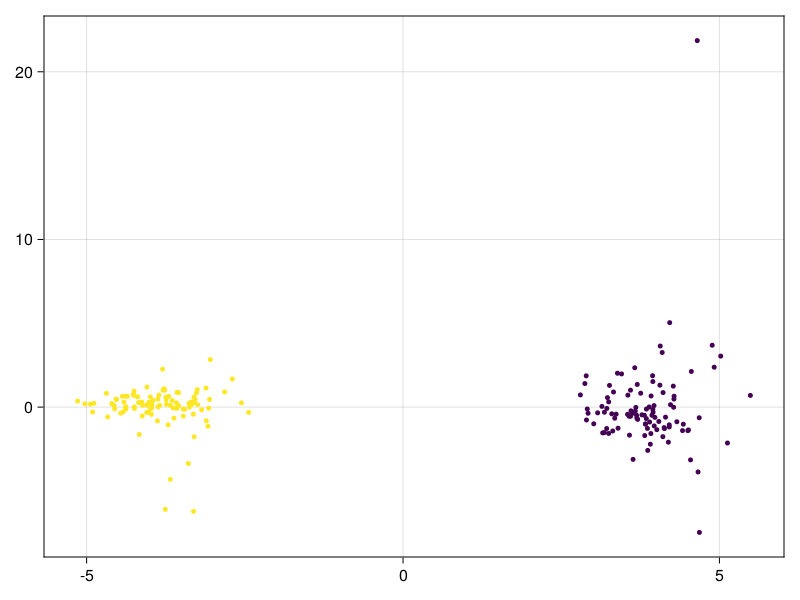

In [16]:
gt = ground_true(tree1,tree2)
tree = vcat(tree1,tree2)
tree = standardize_tree(tree)
pred_kmeans = kmeans_label(tree, 2)
plot_clusters(tree, pred_kmeans)